In [1]:
import ray
import optuna
from torchmetrics import ConfusionMatrix
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,  TensorDataset, Dataset
import torch.nn.functional as F
from ray import tune
import os
import ray
from ray.tune.schedulers import ASHAScheduler
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
confmat = ConfusionMatrix(num_classes=2)
from featurewiz import featurewiz
from sklearn.impute import KNNImputer

Imported version = 0.1.70.
from featurewiz import FeatureWiz
wiz = FeatureWiz(verbose=1)
X_train_selected = wiz.fit_transform(X_train, y_train)
X_test_selected = wiz.transform(X_test)
wiz.features  ### provides a list of selected features ###
                                


############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
You supplied outputs = features
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (27842, 193)
    Loaded train data. Shape = (27842, 193)
    Some column names had special characters which were removed...
No test data filename given...
Classifying features using a random sample of 10000 rows from dataset...
#### Single_Label Binary_Classification problem ####
    loading a random sample of 10000 rows into pandas for EDA
###

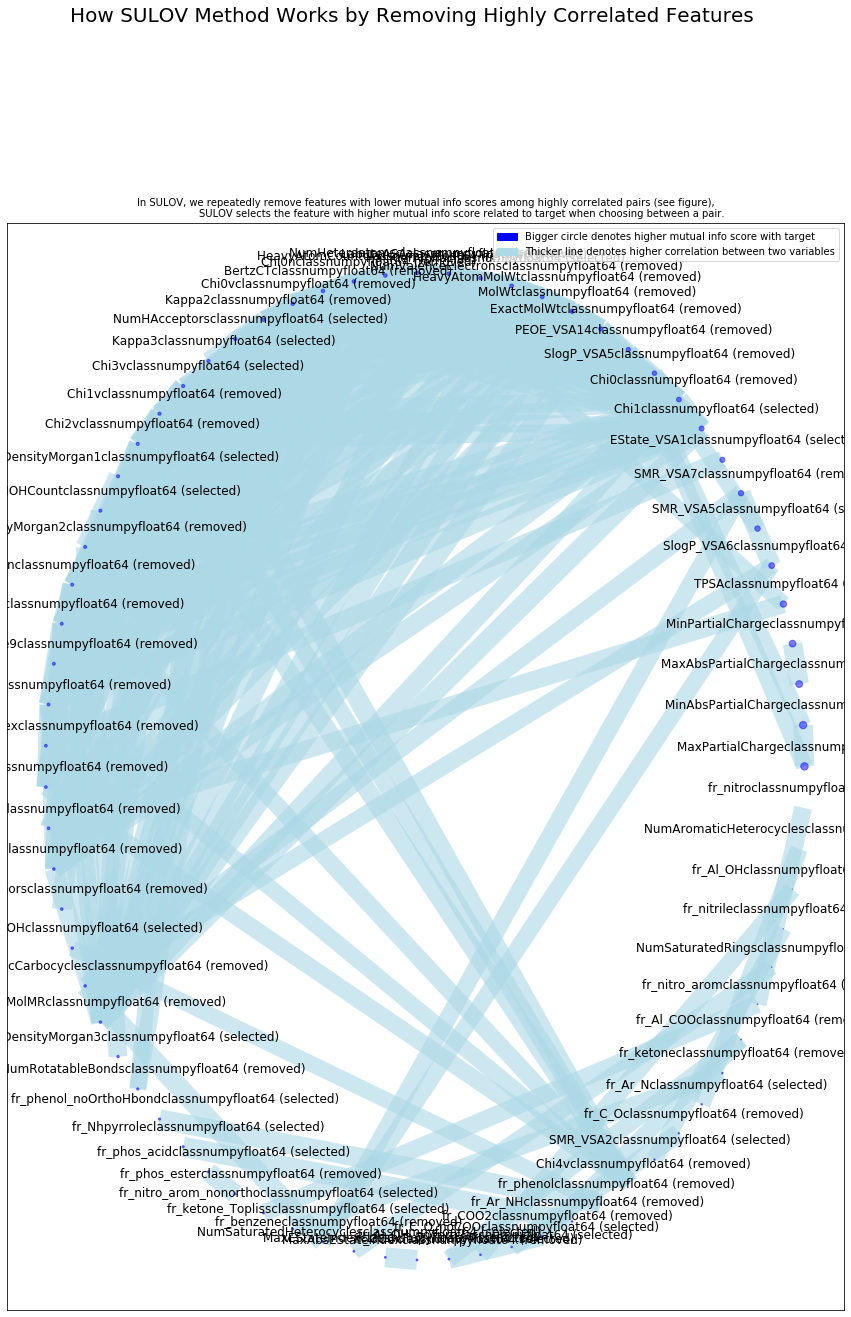

Time taken for SULOV method = 21 seconds
    Adding 0 categorical variables to reduced numeric variables  of 141
Final list of selected vars after SULOV = 141
Readying dataset for Recursive XGBoost by converting all features to numeric...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 141 
    XGBoost version: 1.6.1
Number of booster rounds = 100
        using 141 variables...
            Time taken for regular XGBoost feature selection = 37 seconds
        using 113 variables...
            Time taken for regular XGBoost feature selection = 65 seconds
        using 85 variables...
            Time taken for regular XGBoost feature s

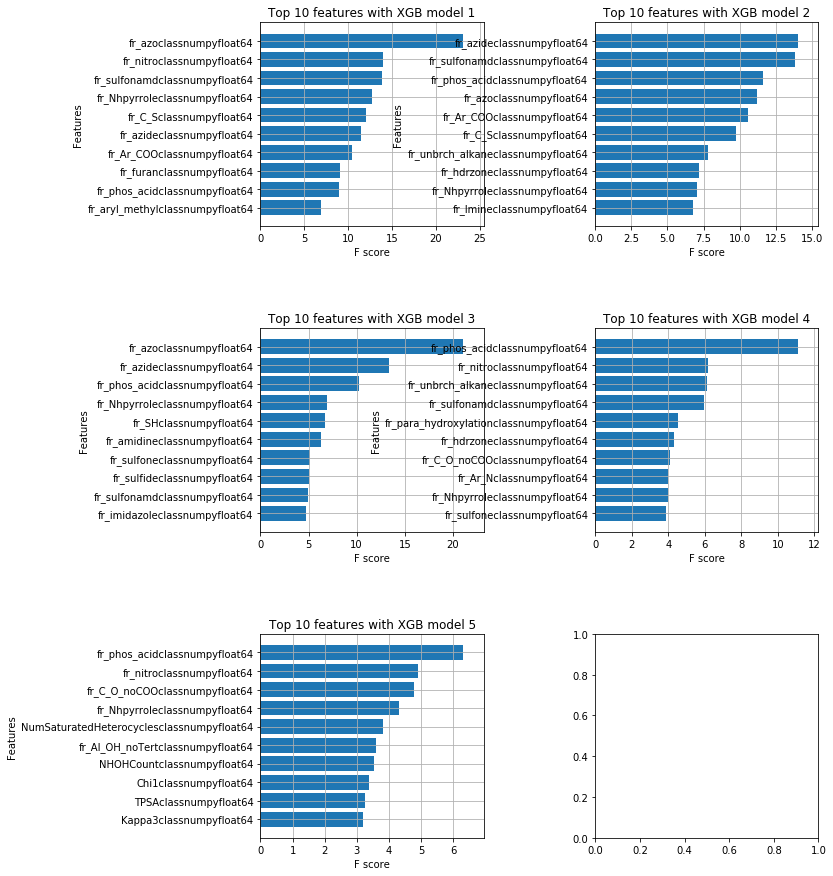

            Total time taken for XGBoost feature selection = 116 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 65 important features. Too many to print...

    Time taken for feature selection = 137 seconds
Returning 2 dataframes: dataname and test_data with 65 important features.


In [2]:
#read data
initial_targets=pd.read_csv("Downloads/Hiv dataset/hiv.csv")
initial_features=pd.read_csv("Downloads/Hiv dataset/hiv_global_cdf_rdkit.csv")

initial_features=initial_features.loc[:, (initial_features != initial_features.iloc[0]).any()] 

shuffled_targets=initial_targets.sample(frac=1,random_state=1234).reset_index(drop=True).drop("smiles",axis=1)
shuffled_features=initial_features.sample(frac=1,random_state=1234).reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(shuffled_features,shuffled_targets,test_size=0.1, random_state=1234,stratify=shuffled_targets["HIV_active"])
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.22, random_state=1234,stratify=y_train["HIV_active"])

#feature selection
Data=pd.concat([X_train, y_train], axis=1)
target = ['HIV_active']
feature_selection = featurewiz(Data.dropna(), target, corr_limit=0.8, verbose=2,header=0, nrows=None,outputs="features")

#dealing with missings
X_train=X_train[feature_selection[0]]
X_valid=X_valid[feature_selection[0]]
X_test=X_test[feature_selection[0]]
y_train=pd.DataFrame(data=y_train)
y_valid=pd.DataFrame(data=y_valid)
y_test=pd.DataFrame(data=y_test)


imputer = KNNImputer(n_neighbors=3)
X_train=pd.DataFrame(data=imputer.fit_transform(X_train))
X_valid=pd.DataFrame(data=imputer.transform(X_valid))
X_test=pd.DataFrame(data=imputer.transform(X_test))


X_train12 ,X_train34 , y_train12, y_train34=train_test_split(X_train,y_train,test_size=0.5, random_state=1234,stratify=y_train["HIV_active"])
X_train1 ,X_train2 , y_train1, y_train2=train_test_split(X_train12,y_train12,test_size=0.5, random_state=1234,stratify=y_train12["HIV_active"])
X_train3 ,X_train4 , y_train3, y_train4=train_test_split(X_train34,y_train34,test_size=0.5, random_state=1234,stratify=y_train34["HIV_active"])
del X_train12
del X_train34
del y_train12
del y_train34
k_fold_X_train=[X_train1 ,X_train2,X_train3 ,X_train4 ]
k_fold_y_train=[y_train1 ,y_train2,y_train3 ,y_train4 ]
del X_train1
del X_train2
del X_train3
del X_train4
del y_train1
del y_train2
del y_train3
del y_train4

k_fold_y_train[0]=pd.DataFrame(data=k_fold_y_train[0])
k_fold_y_train[1]=pd.DataFrame(data=k_fold_y_train[1])
k_fold_y_train[2]=pd.DataFrame(data=k_fold_y_train[2])
k_fold_y_train[3]=pd.DataFrame(data=k_fold_y_train[3])

In [3]:
class HIVDataset_train (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_train.to_numpy().astype("float32")
        self.y=y_train.to_numpy().astype("float32")
        self.n_samples=X_train.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class HIVDataset_train (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_train.to_numpy().astype("float32")
        self.y=y_train.to_numpy().astype("float32")
        self.n_samples=X_train.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class kf_HIVDataset_train (Dataset):
    def __init__(self,k,transform=None):
        #data loading np.delete(np.array([0,1,2,3]),k)
        self.x=(   k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[0]  ].append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[1]  ]).append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[2]  ])   ).to_numpy().astype("float32")
        self.y=(   k_fold_y_train[  np.delete(np.array([0,1,2,3]),k)[0]  ].append(k_fold_y_train[  np.delete(np.array([0,1,2,3]),k)[1]  ]).append(k_fold_y_train[  np.delete(np.array([0,1,2,3]),k)[2]  ])   ).to_numpy().astype("float32")
        self.n_samples=(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[0]  ].append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[1]  ]).append(k_fold_X_train[  np.delete(np.array([0,1,2,3]),k)[2]  ])).shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class kf_HIVDataset_valid (Dataset):
    def __init__(self,k,transform=None):
        #data loading
        self.x=(k_fold_X_train[k]).to_numpy().astype("float32")
        self.y=(k_fold_y_train[k]).to_numpy().astype("float32")
        self.n_samples=(k_fold_X_train[k]).shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class HIVDataset_valid (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_valid.to_numpy().astype("float32")
        self.y=y_valid.to_numpy().astype("float32")
        self.n_samples=X_valid.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples

class HIVDataset_test (Dataset):
    def __init__(self,transform=None):
        #data loading
        self.x=X_test.to_numpy().astype("float32")
        self.y=y_test.to_numpy().astype("float32")
        self.n_samples=X_test.shape[0]
        self.transform=transform
    def __getitem__(self, index):
        sample=self.x[index], self.y[index]
        if self.transform:
            sample=self.transform(sample)
        return sample
    def __len__(self):
        return self.n_samples
    
class ToTensor():
    def __call__(self,sample):
        inputs,targets=sample
        inputs=torch.from_numpy(inputs.astype("float32"))
        targets=torch.tensor(targets.astype("float32"))
        #targets=targets.view(targets.shape[0],1)
        return inputs,targets

#training set ---------------------------------------------------
training_set = HIVDataset_train(transform=ToTensor())    
train_loader = DataLoader(dataset=training_set,
                          batch_size=64,
                          shuffle=True)

dataiter_train = iter(train_loader)
data_train = dataiter_train.next()


def trainloader(config):
    return  DataLoader(dataset=training_set,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
    
#kf-training set ---------------------------------------------------
def kf_trainloader(config,k):
    return  DataLoader(dataset=kf_HIVDataset_train(k,transform=ToTensor())    ,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#kf-training set ---------------------------------------------------
def kf_validloader(config,k):
    return  DataLoader(dataset=kf_HIVDataset_valid(k,transform=ToTensor())    ,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#validation set ---------------------------------------------------
validation_set = HIVDataset_valid(transform=ToTensor())    
valid_loader = DataLoader(dataset=validation_set,
                          batch_size=64,
                          shuffle=True)

dataiter_valid = iter(valid_loader)
data_valid = dataiter_valid.next()

def validloader(config):
    return  DataLoader(dataset=validation_set,
                          batch_size=config["batch_size"],
                          shuffle=True,num_workers=2)
#test set ---------------------------------------------------
test_set = HIVDataset_test(transform=ToTensor())    
test_loader = DataLoader(dataset=test_set,
                          batch_size=8,
                          shuffle=False)

dataiter_test = iter(test_loader)
data_test = dataiter_test.next()

def testloader(config):
    return  DataLoader(dataset=test_set,
                          batch_size=4,
                          shuffle=False,num_workers=2)

In [4]:
n_samples,n_features=X_train.shape
class NeuralNetwork (nn.Module):
    def __init__(self,n_input_features,l1, l2,l3,config):
        super (NeuralNetwork, self).__init__()
        self.config = config
        self.linear1=nn.Linear(n_input_features,n_input_features+l1)
        self.linear2=nn.Linear(n_input_features+l1,math.floor(n_input_features/2)+l2)
        self.D1=torch.nn.Dropout(config.get("drop_out_ratio1"))
        self.linear3=nn.Linear(math.floor(n_input_features/2)+l2,math.floor(n_input_features/4)+l3)
        self.D2=torch.nn.Dropout(config.get("drop_out_ratio2"))
        self.linear5=nn.Linear(math.floor(n_input_features/4)+l3,1)

        self.a1 = self.config.get("a1")
        self.a2 = self.config.get("a2")
        self.a3 = self.config.get("a3")


    @staticmethod
    def activation_func(act_str):
        if act_str=="tanh" or act_str=="sigmoid":
            return eval("torch."+act_str)
        elif act_str=="silu" or act_str=="relu" or act_str=="leaky_relu" or act_str=="gelu":   
            return eval("torch.nn.functional."+act_str)

    def forward(self,x):
        out=self.linear1(x)
        out=self.activation_func(self.a1)(out.float())
        out=self.linear2(out)
        out=self.D1(out)
        out=self.activation_func(self.a2)(out.float())
        out=self.linear3(out)
        out=self.activation_func(self.a3)(out.float())
        out=self.D1(out)
        out=self.linear5(out)
        out=torch.sigmoid(out)
        y_predicted=out
        return y_predicted

In [5]:
from sklearn.metrics import roc_auc_score

def compute_score(model, data_loader, device="cpu"):
    model.eval()
    metric = roc_auc_score
    with torch.no_grad():
        prediction_all= torch.empty(0, device=device)
        labels_all= torch.empty(0, device=device)
        for i, (feats, labels) in enumerate(data_loader):
            feats=feats.to(device)
            labels=labels.to(device)
            prediction = model(feats).to(device)
            prediction = torch.sigmoid(prediction).to(device)
            prediction_all = torch.cat((prediction_all, prediction), 0)
            labels_all = torch.cat((labels_all, labels), 0)                
        try:
            t = metric(labels_all.int().cpu(), prediction_all.cpu()).item()
        except ValueError:
            t = 0
    return t

In [6]:
def train_HIV(config,checkpoint_dir=None,max_iter=11):
    net = NeuralNetwork(np.shape(feature_selection[0])[0],config["l1"],config["l2"],config["l3"],config)


    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    #Define my loss function and optimizer
    criterion=nn.BCELoss()
    optimizer=torch.optim.Adam(net.parameters(), lr=config["lr"])
    
    
    # The `checkpoint_dir` parameter gets passed by Ray Tune when a checkpoint
    # should be restored.
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
        
   

    localiter=0
    for epoch in range(max_iter):  # loop over the dataset multiple times
        running_loss1 = 0.0
        epoch_steps1 = 0
        for i, data in enumerate(kf_trainloader(config,1), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss1 += loss.item()
            epoch_steps1 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss1 / epoch_steps1))
                running_loss1 = 0.0


        # Validation score
        score1 = compute_score(net, kf_validloader(config,1), device="cpu")

    #second loop -----------------------------
   
        running_loss2 = 0.0
        epoch_steps2 = 0
        for i, data in enumerate(kf_trainloader(config,2), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss2 += loss.item()
            epoch_steps2 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss2 / epoch_steps2))
                running_loss2 = 0.0


        # Validation score
        
        score2 = compute_score(net, kf_validloader(config,2), device="cpu")
   
    #third loop -----------------------------
   
        running_loss3 = 0.0
        epoch_steps3 = 0
        for i, data in enumerate(kf_trainloader(config,3), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss3 += loss.item()
            epoch_steps3 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss3 / epoch_steps3))
                running_loss3 = 0.0


        # Validation score
        
        score3 = compute_score(net, kf_validloader(config,3), device="cpu")

    #forth loop -----------------------------
      # loop over the dataset multiple times
        running_loss4 = 0.0
        epoch_steps4 = 0
        for i, data in enumerate(kf_trainloader(config,0), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss4 += loss.item()
            epoch_steps4 += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss4 / epoch_steps4))
                running_loss4 = 0.0


        # Validation score
        
        score4 = compute_score(net, kf_validloader(config,0), device="cpu")

    #global loop -----------------------------
    for layer in net.children():
      if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
    for epoch in range(max_iter):
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader(config), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss / epoch_steps))
                running_loss = 0.0
   

        # Validation score
        
        kf_score=np.min([score1,score2,score3,score4])
       

        localiter=localiter+1
        val_score = compute_score(net, validloader(config), device="cpu")

        score=np.mean([val_score,val_score,kf_score])-((localiter/max_iter)**2)*0.04-(kf_score-val_score)/4
        



        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
        tune.report(score=score,kf_score=kf_score,val_score=val_score)

    print("Finished Training")

In [7]:
def test_best_model(best_trial):
    best_trained_model = NeuralNetwork(np.shape(feature_selection[0])[0],best_trial.config["l1"],best_trial.config["l2"],best_trial.config["l3"],best_trial.config)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_trial.checkpoint.value, "checkpoint")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    test_score = compute_score(best_trained_model, testloader(best_trial.config), device)
    print("Best trial test set score:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - {} ".format(test_score))
    return best_trial.config, best_trained_model

In [8]:
config = {
      "l1": tune.choice([2**6,2**7,2**8]),
      "l2": tune.choice([2**6,2**7,2**8]),
      "l3": tune.choice([2**6,2**7,2**8]),
      "lr": tune.loguniform(1e-4, 1e-1),
      "drop_out_ratio1": tune.uniform(0.3, 0.65),
      "drop_out_ratio2": tune.loguniform(1e-2, 1),
      "a1":tune.choice(["relu","leaky_relu","silu"]),
      "a2":tune.choice(["gelu","leaky_relu"]),
      "a3":tune.choice(["relu", "gelu"]),
      "batch_size": tune.choice([ 32, 64, 128]),   
      }

In [9]:
from ray.tune import CLIReporter
from functools import partial

In [10]:
def main(num_samples=10, max_num_epochs=100, gpus_per_trial=2):

    config = {
      "l1": tune.choice([2**6,2**7,2**8]),
      "l2": tune.choice([2**6,2**7,2**8]),
      "l3": tune.choice([2**6,2**7,2**8]),
      "lr": tune.loguniform(1e-4, 1e-1),
      "drop_out_ratio1": tune.uniform(0.3, 0.65),
      "drop_out_ratio2": tune.loguniform(1e-2, 1),
      "a1":tune.choice(["relu","leaky_relu","silu"]),
      "a2":tune.choice(["gelu","leaky_relu"]),
      "a3":tune.choice(["relu", "gelu"]),
      "batch_size": tune.choice([ 32, 64, 128]),   
      }


    from ray.tune.suggest.optuna import OptunaSearch 

    from ray.tune.suggest import ConcurrencyLimiter
    search_alg = OptunaSearch(
       metric="score", #or accuracy, etc.
       mode="max", #or max
       seed = 42,
       )
    search_alg = ConcurrencyLimiter(search_alg, max_concurrent=10)

    scheduler = ASHAScheduler(
        metric ="score",
        mode="max",
        max_t=max_num_epochs,
        reduction_factor=2, 
        grace_period=4,
        brackets=5
        )
    
    reporter = CLIReporter(
        metric_columns=["score","val_score","kf_score" ,"training_iteration"]
        )
    
    # wrap data loading and training for tuning using `partial` 
    # (note that there exist other methods for this purpose)
    max_iter=max_num_epochs
    result = tune.run(
        partial(train_HIV,max_iter=max_iter),
        scheduler=scheduler,
        search_alg=search_alg,
        num_samples=num_samples,
        config=config,
        verbose=3,
        checkpoint_score_attr="score",
        checkpoint_freq=0,
        keep_checkpoints_num=1,
        progress_reporter=reporter,
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        stop={"training_iteration": max_iter},                
        )


    
    best_trial = result.get_best_trial("score", "max", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Average ROC_AUC score of the chosen model for different validation sets in 4-fold cross validation: {}".format(best_trial.last_result["kf_score"]))
    print("Best trial final validation ROC_AUC:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - {} ".format(best_trial.last_result["val_score"]))
    print("Best trial final score: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - {}".format(best_trial.last_result["score"]))

    if ray.util.client.ray.is_connected():
        # If using Ray Client, we want to make sure checkpoint access
        # happens on the server. So we wrap `test_best_model` in a Ray task.
        # We have to make sure it gets executed on the same node that
        # ``tune.run`` is called on.
        from ray.util.ml_utils.node import force_on_current_node
        remote_fn = force_on_current_node(ray.remote(test_best_model))
        ray.get(remote_fn.remote(best_trial))
    else:
       best_trial.config, best_trained_model=test_best_model(best_trial)
    print("----------------------------------------------------------------------------------------------------------------")
    return best_trial.config, best_trained_model

configuration,Bneuralnetwork=main(num_samples=10, max_num_epochs=8, gpus_per_trial=0)

[I 2022-07-21 09:15:16,073] A new study created in memory with name: optuna
2022-07-21 09:15:18,909	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (57 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
2022-07-21 09:15:20,140	WARNING util.py:214 -- The `start_trial` operation took 2.503 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-21 09:15:20 (running for 00:00:03.94)
Memory usage on this node: 3.7/15.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None
Bracket: Iter 8.000: None
Bracket: 
Bracket: 
Bracket: 
Resources requested: 2.0/8 CPUs, 0/0 GPUs, 0.0/7.9 GiB heap, 0.0/3.95 GiB objects
Result logdir: /home/arash/ray_results/train_HIV_2022-07-21_09-15-16
Number of trials: 1/10 (1 RUNNING)
+--------------------+----------+----------------------+------+------------+------+--------------+-------------------+-------------------+------+------+------+-----------+
| Trial name         | status   | loc                  | a1   | a2         | a3   |   batch_size |   drop_out_ratio1 |   drop_out_ratio2 |   l1 |   l2 |   l3 |        lr |
|--------------------+----------+----------------------+------+------------+------+--------------+-------------------+-------------------+------+------+------+-----------|
| train_HIV_a248d69e | RUNNING  | 193.141.126.11

2022-07-21 09:15:27,773	WARNING util.py:214 -- The `start_trial` operation took 1.131 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-21 09:15:27 (running for 00:00:11.57)
Memory usage on this node: 4.0/15.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None
Bracket: Iter 8.000: None
Bracket: 
Bracket: 
Bracket: 
Resources requested: 4.0/8 CPUs, 0/0 GPUs, 0.0/7.9 GiB heap, 0.0/3.95 GiB objects
Result logdir: /home/arash/ray_results/train_HIV_2022-07-21_09-15-16
Number of trials: 2/10 (2 RUNNING)
+--------------------+----------+----------------------+------+------------+------+--------------+-------------------+-------------------+------+------+------+-------------+
| Trial name         | status   | loc                  | a1   | a2         | a3   |   batch_size |   drop_out_ratio1 |   drop_out_ratio2 |   l1 |   l2 |   l3 |          lr |
|--------------------+----------+----------------------+------+------------+------+--------------+-------------------+-------------------+------+------+------+-------------|
| train_HIV_a248d69e | RUNNING  | 193.141.

2022-07-21 09:15:36,552	WARNING util.py:214 -- The `start_trial` operation took 1.033 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-21 09:15:36 (running for 00:00:20.38)
Memory usage on this node: 4.4/15.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None
Bracket: Iter 8.000: None
Bracket: 
Bracket: 
Bracket: 
Resources requested: 6.0/8 CPUs, 0/0 GPUs, 0.0/7.9 GiB heap, 0.0/3.95 GiB objects
Result logdir: /home/arash/ray_results/train_HIV_2022-07-21_09-15-16
Number of trials: 3/10 (3 RUNNING)
+--------------------+----------+----------------------+------------+------------+------+--------------+-------------------+-------------------+------+------+------+-------------+
| Trial name         | status   | loc                  | a1         | a2         | a3   |   batch_size |   drop_out_ratio1 |   drop_out_ratio2 |   l1 |   l2 |   l3 |          lr |
|--------------------+----------+----------------------+------------+------------+------+--------------+-------------------+-------------------+------+------+------+-------------|
| train_HIV_a248d69e | R

2022-07-21 09:15:45,690	WARNING util.py:214 -- The `start_trial` operation took 1.035 s, which may be a performance bottleneck.


== Status ==
Current time: 2022-07-21 09:15:45 (running for 00:00:29.50)
Memory usage on this node: 4.6/15.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None
Bracket: Iter 8.000: None
Bracket: 
Bracket: 
Bracket: 
Resources requested: 8.0/8 CPUs, 0/0 GPUs, 0.0/7.9 GiB heap, 0.0/3.95 GiB objects
Result logdir: /home/arash/ray_results/train_HIV_2022-07-21_09-15-16
Number of trials: 4/10 (4 RUNNING)
+--------------------+----------+----------------------+------------+------------+------+--------------+-------------------+-------------------+------+------+------+-------------+
| Trial name         | status   | loc                  | a1         | a2         | a3   |   batch_size |   drop_out_ratio1 |   drop_out_ratio2 |   l1 |   l2 |   l3 |          lr |
|--------------------+----------+----------------------+------------+------------+------+--------------+-------------------+-------------------+------+------+------+-------------|
| train_HIV_a248d69e | R

2022-07-21 09:29:01,993	INFO tune.py:748 -- Total run time: 827.29 seconds (825.50 seconds for the tuning loop).


Best trial config: {'l1': 256, 'l2': 64, 'l3': 256, 'lr': 0.00032476735706274504, 'drop_out_ratio1': 0.32276805754484783, 'drop_out_ratio2': 0.7902619549708229, 'a1': 'relu', 'a2': 'leaky_relu', 'a3': 'relu', 'batch_size': 128}
Average ROC_AUC score of the chosen model for different validation sets in 4-fold cross validation: 0.9382071282442705
Best trial final validation ROC_AUC:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 0.8102221334277837 
Best trial final score: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 0.780887549662491
Best trial test set score:- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 0.8114283264746227 
----------------------------------------------------------------------------------------------------------------


In [11]:
X_test_=torch.tensor(X_test.values).float()
X_train_=torch.tensor(X_train.values).float()
y_test_=torch.tensor(y_test.values).float()
X_valid_=torch.tensor(X_valid.values).float()
y_valid_=torch.tensor(y_valid.values).float()
y_train_=torch.tensor(y_train.values).float()
y_test_=y_test_.view(y_test.shape[0],1)
y_valid_=y_valid_.view(y_valid.shape[0],1)
y_train_=y_train_.view(y_train.shape[0],1)

print("training set:")
with torch.no_grad():
  y_predicted=Bneuralnetwork(X_train_)
  y_predicted_cls=y_predicted.round()
  acc= y_predicted_cls.eq(y_train_).sum()/float(y_train_.shape[0])
  a=confmat( y_predicted_cls.int(),y_train_.int()) 
  print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_train_.int()):.19f}     ROC_AUC={compute_score(Bneuralnetwork, trainloader(configuration), device="cpu")   :.19f}')
  print(a)

print("validation set:")
with torch.no_grad():
  y_predicted=Bneuralnetwork(X_valid_)
  y_predicted_cls=y_predicted.round()
  acc= y_predicted_cls.eq(y_valid_).sum()/float(y_valid_.shape[0])
  a=confmat( y_predicted_cls.int(),y_valid_.int()) 
  print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_valid_.int()):.19f}     ROC_AUC={compute_score(Bneuralnetwork, validloader(configuration), device="cpu")   :.19f}')
  print(a)

print("test set:")
with torch.no_grad():
  y_predicted=Bneuralnetwork(X_test_)
  y_predicted_cls=y_predicted.round()
  acc= y_predicted_cls.eq(y_test_).sum()/float(y_test_.shape[0])
  a=confmat( y_predicted_cls.int(),y_test_.int()) 
  print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_test_.int()):.19f}     ROC_AUC={compute_score(Bneuralnetwork, testloader(configuration), device="cpu")   :.19f}')
  print(a)

training set:
accuracy=0.9706615805625915527     balanced_accuracy_score=0.8875942784096189087     ROC_AUC=0.8499006755733635732
tensor([[27803,    54],
        [  793,   220]])
validation set:
accuracy=0.9696709513664245605     balanced_accuracy_score=0.8658098897013259965     ROC_AUC=0.8102221334277837084
tensor([[7840,   18],
        [ 229,   57]])
test set:
accuracy=0.9698516726493835449     balanced_accuracy_score=0.8674685179205683383     ROC_AUC=0.8114283264746227076
tensor([[3960,    9],
        [ 115,   29]])


In [18]:
def final_traing(config,max_iter=15):
    net = NeuralNetwork(np.shape(feature_selection[0])[0],config["l1"],config["l2"],config["l3"],config)


    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    
    #Define my loss function and optimizer
    criterion=nn.BCELoss()
    optimizer=torch.optim.Adam(net.parameters(), lr=config["lr"])

    for epoch in range(max_iter):
      running_loss = 0.0
      epoch_steps = 0
      for i, data in enumerate(trainloader(config), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        epoch_steps += 1
        if i % 2000 == 1999:  # print every 2000 mini-batches
          print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,running_loss / epoch_steps))
          running_loss = 0.0

        # Validation score
    score = compute_score(net, validloader(config), device="cpu")
    print(score)
    score = compute_score(net, testloader(config), device="cpu")
    print(score)
    print(config)
    return net

neurlnet=final_traing(configuration,max_iter=9)



0.8026851616187326
0.812192932728647
{'l1': 256, 'l2': 64, 'l3': 256, 'lr': 0.00032476735706274504, 'drop_out_ratio1': 0.32276805754484783, 'drop_out_ratio2': 0.7902619549708229, 'a1': 'relu', 'a2': 'leaky_relu', 'a3': 'relu', 'batch_size': 128}


In [19]:
with torch.no_grad():
    y_predicted=neurlnet(X_test_)
    y_predicted_cls=y_predicted.round()
    acc= y_predicted_cls.eq(y_test_).sum()/float(y_test_.shape[0])

    #print(f'accuracy={acc:.4f}')
    a=confmat( y_predicted_cls.int(),y_test_.int()) 
    print(f'accuracy={acc:.19f}     balanced_accuracy_score={balanced_accuracy_score(y_predicted_cls.int(),y_test_.int()):.19f}     ROC_AUC={compute_score(neurlnet, testloader(configuration), device="cpu")   :.19f}')
    print(a)

accuracy=0.9710673689842224121     balanced_accuracy_score=0.8696978576885642243     ROC_AUC=0.8121929327286470102
tensor([[3958,   11],
        [ 108,   36]])
